In [1]:
import time
import cv2
import datetime
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from scipy.spatial.distance import cdist
from skimage.feature import hog, local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
def showimage(image, train):
    if train == True:
        plt.imshow(x_train[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (y_train[image])
    else:
        plt.imshow(x_test[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (y_test[image])

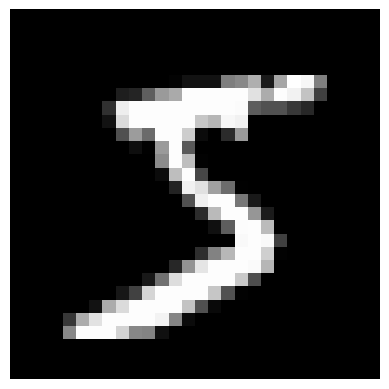

5

In [4]:
showimage(0,1)

# Flatten

In [5]:
def flatten(train, test):
    
    return train.reshape(train.shape[0], -1), test.reshape(test.shape[0], -1)

# PCA

In [6]:
def pca(train, test, variance):
    
    train_flatten, test_flatten = flatten(train, test)
    
    pca = PCA(n_components = variance)
    pca.fit(train_flatten)
    
    return pca.transform(train_flatten), pca.transform(test_flatten)

# SIFT

In [7]:
def sift(train, test, num_cluster):
    
    sift = cv2.SIFT_create()
    
    sift_descriptors_train = []
    for image in train:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_train.append(des)
        
    sift_descriptors_test = []
    for image in test:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_test.append(des)
        
    sift_all_descriptors = []
    for descriptor in sift_descriptors_train:
        if descriptor is not None:
            for des in descriptor:
                sift_all_descriptors.append(des)
                
    sift_bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(sift_all_descriptors)
    sift_bow_dict = kmeans.cluster_centers_
    
    train_sift = []
    for image in sift_descriptors_train:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        train_sift.append(features)

    test_sift = []
    for image in sift_descriptors_test:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        test_sift.append(features)
        
    return np.array(train_sift), np.array(test_sift)

# HOG

In [8]:
def c_hog(train, test, orientations, ppc, cpb):
    
    train_hog = []
    test_hog = []

    for image in train:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        train_hog.append(fd)

    for image in test:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        test_hog.append(fd)
        
    return np.array(train_hog), np.array(test_hog)

# LBP

In [9]:
def lbp(train, test, radius):

    train_lbp = []
    test_lbp = []

    for image in train:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        hist, _ = np.histogram(lbp, bins=8 * radius + 2, range=(0, 8 * radius + 2), density=True)
        train_lbp.append(hist)

    for image in test:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        hist, _ = np.histogram(lbp, bins=8 * radius + 2, range=(0, 8 * radius + 2), density=True)
        test_lbp.append(hist)
        
    return np.array(train_lbp), np.array(test_lbp)

# Optimize

### PCA

In [ ]:
var = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for i in var:
    for j in range(0,5):
        start = time.time()
        train_x, valid_x = pca(x_train[j*12000:j*12000+2000], x_train[j*12000+2000:(j+1)*12000], i)
        
        train_y = y_train[j*12000:j*12000+2000]
        valid_y = y_train[j*12000+2000:(j+1)*12000]

        kernel = RationalQuadratic()
        gpc = GaussianProcessClassifier(kernel=kernel)
        gpc.fit(train_x, train_y)

        pred_y = gpc.predict(valid_x)
        end = time.time()
        print(datetime.timedelta(seconds = int(end-start)))
        print([i, j+1])
        print(accuracy_score(valid_y, pred_y))

In [ ]:
# 0.5 [0.8467,0.8522,0.8394,0.8412,0.877]
# 0.6 [0.8858,0.8796,0.8718,0.8699,0.8959]
# 0.7 [0.897,0.8937,0.8852,0.882,0.9088]
# 0.8 [0.8989,0.8962,0.8883,0.8836,0.9078]
# 0.9 [0.8946,0.889,0.887,0.8792,0.9048]
# 0.99 [0.8889,0.8834,0.8811,0.8729,0.9002]

### SIFT

In [ ]:
sift = cv2.SIFT_create()

sift_descriptors_train = []
for image in x_train:
    kp, des = sift.detectAndCompute(image, None)
    sift_descriptors_train.append(des)

sift_all_descriptors = []
for descriptor in sift_descriptors_train:
    if descriptor is not None:
        for des in descriptor:
            sift_all_descriptors.append(des)

In [ ]:
num = [i for i in range(10,201,10)]
for num_cluster in num:
    
    start = time.time()
    sift_bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(sift_all_descriptors)
    sift_bow_dict = kmeans.cluster_centers_

    train_sift = []
    for image in sift_descriptors_train:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        train_sift.append(features)
    
    for j in range(0,5):
    
        train_x = train_sift[j*12000:j*12000+2000]
        valid_x = train_sift[j*12000+2000:(j+1)*12000]
        train_y = y_train[j*12000:j*12000+2000]
        valid_y = y_train[j*12000+2000:(j+1)*12000]

        kernel = RationalQuadratic()
        gpc = GaussianProcessClassifier(kernel=kernel)
        gpc.fit(train_x, train_y)

        pred_y = gpc.predict(valid_x)
        end = time.time()
        print(datetime.timedelta(seconds = int(end-start)))
        print([num_cluster, j+1])
        print(accuracy_score(valid_y, pred_y))

In [ ]:
# 10 [0.4165,0.4102,0.406,0.3929,0.3945]
# 20 [0.5082,0.5069,0.5057,0.4969,0.5132]
# 30 [0.5345,0.5323,0.5308,0.529,0.532]
# 40 [0.6017,0.5868,0.5851,0.5943,0.5864]
# 50 [0.6015,0.6119,0.6122,0.6042,0.6083]
# 60 [0.6261,0.6071,0.616,0.6118,0.6165]
# 70 [0.6556,0.6303,0.6386,0.6349,0.6409]
# 80 [0.6332,0.6318,0.6349,0.6393,0.6464]
# 90 [0.651,0.6455,0.6516,0.6546,0.6603]
# 100 [0.6601,0.6478,0.663,0.6623,0.6657]
# 110 [0.6987,0.6907,0.6759,0.6811,0.6869]
# 120 [0.6724,0.6706,0.679,0.6829,0.6834]
# 130 [0.6991,0.6988,0.6802,0.6804,0.6875]
# 140 [0.6741,0.6759,0.6921,0.6904,0.6965]
# 150 [0.7129,0.7135,0.7029,0.6976,0.6992]
# 160 [0.7144,0.716,0.7039,0.7028,0.7051]
# 170 [0.7114,0.7119,0.7046,0.7042,0.7024]
# 180 [0.7176,0.7177,0.7066,0.7041,0.7079]
# 190 [0.7211,0.7195,0.7054,0.7078,0.7145]
# 200 [0.7221,0.7258,0.7155,0.7092,0.7094]

### HOG

In [ ]:
ori = [9]
ppc = [4]
cpb = [4,5,6,7,8]
for i in ori:
    for j in ppc:
        for k in cpb:
            for l in range(0,5):
                
                start = time.time()
                train_x, valid_x = c_hog(x_train[l*12000:l*12000+2000], x_train[l*12000+2000:(l+1)*12000], i, j, k)

                train_y = y_train[l*12000:l*12000+2000]
                valid_y = y_train[l*12000+2000:(l+1)*12000]

                kernel = RationalQuadratic()
                gpc = GaussianProcessClassifier(kernel=kernel)
                gpc.fit(train_x, train_y)

                pred_y = gpc.predict(valid_x)
                end = time.time()
                print(datetime.timedelta(seconds = int(end-start)))
                print([i, j, k, l+1])
                print(accuracy_score(valid_y, pred_y))

In [ ]:
# 841 [0.9373,0.937,0.9385,0.9282,0.9461]
# 842 [0.9379,0.9403,0.9398,0.9295,0.95]
# 843 [0.943,0.9494,0.9436,0.9387,0.9554]
# 881 [0.8803,0.8796,0.8787,0.8737,0.8973]
# 882 [0.9013,0.9101,0.9097,0.8955,0.9195]
# 883 [0.9113,0.9231,0.9175,0.908,0.9261]
# 941 [0.9377,0.9357,0.9394,0.9313,0.9467]
# 942 [0.9377,0.9381,0.9433,0.9317,0.9496]
# 943 [0.9425,0.9496,0.9461,0.9403,0.9563]
# 981 [0.8838,0.8822,0.8842,0.8698,0.899]
# 982 [0.9049,0.9084,0.9099,0.8973,0.9213]
# 983 [0.9154,0.9214,0.9158,0.9129,0.931]

### LBP

In [10]:
rad = [i for i in range(1,30)]
for i in rad:
    for j in range(0,5):
        
        start = time.time()
        train_x, valid_x = lbp(x_train[j*12000:j*12000+2000], x_train[j*12000+2000:(j+1)*12000], i)
        
        train_y = y_train[j*12000:j*12000+2000]
        valid_y = y_train[j*12000+2000:(j+1)*12000]

        kernel = RationalQuadratic()
        gpc = GaussianProcessClassifier(kernel=kernel)
        gpc.fit(train_x, train_y)

        pred_y = gpc.predict(valid_x)
        end = time.time()
        print(datetime.timedelta(seconds = int(end-start)))
        print([i, j+1])
        print(accuracy_score(valid_y, pred_y))

0:03:43
[1, 1]
0.3752
0:04:00
[1, 2]
0.3648


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:00
[1, 3]
0.3716
0:04:08
[1, 4]
0.3769


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:17
[1, 5]
0.3785


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:43
[2, 1]
0.493


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:07
[2, 2]
0.4888


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:06
[2, 3]
0.4922


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:48
[2, 4]
0.4881


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:14
[2, 5]
0.4983


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:15
[3, 1]
0.4787
0:03:31
[3, 2]
0.4855


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:25
[3, 3]
0.4924


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:19
[3, 4]
0.4835


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:30
[3, 5]
0.4972


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:40
[4, 1]
0.4338
0:03:45
[4, 2]
0.4423


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:50
[4, 3]
0.4416


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:41
[4, 4]
0.4344
0:03:38
[4, 5]
0.445


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:29
[5, 1]
0.4288


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:58
[5, 2]
0.4406


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:49
[5, 3]
0.4477
0:03:38
[5, 4]
0.4379


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:56
[5, 5]
0.4491


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:42
[6, 1]
0.4448


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:00
[6, 2]
0.4455


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:54
[6, 3]
0.4467


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:45
[6, 4]
0.4504


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:59
[6, 5]
0.4584


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:34
[7, 1]
0.439


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:59
[7, 2]
0.4356


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:38
[7, 3]
0.4372


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:47
[7, 4]
0.4377


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:49
[7, 5]
0.4543


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:45
[8, 1]
0.4333


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:54
[8, 2]
0.4263


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:51
[8, 3]
0.4275


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:00
[8, 4]
0.4245


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:47
[8, 5]
0.4468


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:45
[9, 1]
0.4262


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:08
[9, 2]
0.4166


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:50
[9, 3]
0.4229


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:09
[9, 4]
0.4181
0:04:08
[9, 5]
0.4376


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:10
[10, 1]
0.4278


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:08
[10, 2]
0.4082


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:14
[10, 3]
0.4214


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:00
[10, 4]
0.4158
0:04:46
[10, 5]
0.4229


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:57
[11, 1]
0.4418
0:04:12
[11, 2]
0.4273


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:03:59
[11, 3]
0.4386


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:18
[11, 4]
0.4311


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:03
[11, 5]
0.4397


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:15
[12, 1]
0.4667


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:14
[12, 2]
0.4593


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:45
[12, 3]
0.4625


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:25
[12, 4]
0.4612
0:03:53
[12, 5]
0.4741
0:04:07
[13, 1]
0.4783


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:40
[13, 2]
0.4737


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:35
[13, 3]
0.4732


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:55
[13, 4]
0.4789
0:03:48
[13, 5]
0.4872
0:04:21
[14, 1]
0.4747
0:04:01
[14, 2]
0.4824
0:04:42
[14, 3]
0.4774
0:04:09
[14, 4]
0.4841
0:04:12
[14, 5]
0.4842


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:22
[15, 1]
0.4776
0:04:26
[15, 2]
0.4811


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:41
[15, 3]
0.4839
0:04:25
[15, 4]
0.4841
0:04:11
[15, 5]
0.4874
0:04:52
[16, 1]
0.4714
0:04:03
[16, 2]
0.4837
0:04:10
[16, 3]
0.4721
0:04:11
[16, 4]
0.4723
0:04:13
[16, 5]
0.478


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:18
[17, 1]
0.4439
0:04:11
[17, 2]
0.4445
0:04:04
[17, 3]
0.439
0:04:21
[17, 4]
0.4419
0:04:04
[17, 5]
0.4465


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:45
[18, 1]
0.4058
0:04:10
[18, 2]
0.4027
0:04:28
[18, 3]
0.3918
0:04:46
[18, 4]
0.4044
0:04:42
[18, 5]
0.4079
0:04:45
[19, 1]
0.3656


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:49
[19, 2]
0.3558


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:18
[19, 3]
0.3422
0:04:39
[19, 4]
0.3619


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:42
[19, 5]
0.3664


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:56
[20, 1]
0.3249


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:43
[20, 2]
0.3028


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:32
[20, 3]
0.3014
0:04:44
[20, 4]
0.3016


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:52
[20, 5]
0.3192


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:46
[21, 1]
0.3016


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:03
[21, 2]
0.2856


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:11
[21, 3]
0.2893


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:15
[21, 4]
0.2836


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:04:41
[21, 5]
0.3015


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:40
[22, 1]
0.2763


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:14
[22, 2]
0.2711


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:25
[22, 3]
0.2891


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:50
[22, 4]
0.2718


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:23
[22, 5]
0.2765


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:06:12
[23, 1]
0.2651


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:13
[23, 2]
0.2613


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:39
[23, 3]
0.2725
0:04:44
[23, 4]
0.251


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:04
[23, 5]
0.2653


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:33
[24, 1]
0.2544


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:38
[24, 2]
0.2508


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:27
[24, 3]
0.2611


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:15
[24, 4]
0.2458


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:21
[24, 5]
0.2608


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:32
[25, 1]
0.2525


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:36
[25, 2]
0.254


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:32
[25, 3]
0.2532


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:22
[25, 4]
0.2455


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:40
[25, 5]
0.2596


C:\Users\pongp\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0:05:30
[26, 1]
0.2523


KeyboardInterrupt: 